## Co-moving stars in Kepler

(done in a very hacky way) (but this is probably ok because we're assuming all the stars are far away)

In [113]:
import numpy as np
from astropy.table import Table, unique
from astropy import units as u
import astropy.coordinates as coord
from astropy.time import Time
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

Load up the table, which was made with Gaia Archive xmatch, and remove sources without good parallax measures:

In [123]:
kepler_table_file = '../data/kepler-result.fits'
table = Table.read(kepler_table_file, format='fits')

In [124]:
filter = (table['phot_g_mean_mag'] >= 18.) & (table['parallax'] > 0.01)
table = table[filter]

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Calculate angular separations. We'll also need some of this info later, so we'll save it in a copy table.

In [125]:
kicCoord = coord.SkyCoord(ra=table['ra_kic'] * u.deg, dec=table['dec_kic'] * u.deg)
table['radial_velocity'][np.isnan(table['radial_velocity'])] = 0.
gaia_time = Time('2015-01-01')
gaiaCoord = coord.SkyCoord(ra=np.array(table['ra'])*u.deg, 
                        dec=np.array(table['dec'])*u.deg, 
                        distance=(np.array(table['parallax'])*u.mas).to(u.pc, u.parallax()),
                        radial_velocity=np.array(table['radial_velocity'])*u.km/u.s,
                        pm_ra_cosdec=np.array(table['pmra'])*u.mas/u.yr, 
                        pm_dec=np.array(table['pmdec'])*u.mas/u.yr, 
                        obstime=gaia_time
                        )
table['angDist'] = kicCoord.separation(gaiaCoord)

In [126]:
plot_table = table['designation','phot_g_mean_mag','ra','dec',
                          'parallax','radial_velocity','pmra','pmdec'].copy()

Now convert to pandas for massive speed boosts. We'll also sort such that for each KIC ID, the best match comes first:

In [4]:
table = table.to_pandas()

In [5]:
table.sort_values(['kepid', 'angDist'], inplace=True)

Define some useful functions:

In [28]:
def ppm_check(star1, star2, sigma=5.):
    """
    Returns True if the differences between parallax, pmra, and pmdec are all below 
    the sigma threshold.
    """
    names = ['parallax', 'pmra', 'pmdec']
    for name in names:
        err = np.sqrt(star1[name+'_error']**2 + star2[name+'_error']**2)
        if np.isnan(star1[name]) or np.isnan(star2[name]) or np.isnan(err):
            return False
        if (np.abs(star1[name] - star2[name])/err) >= sigma:
            return False
    return True

In [29]:
def make_x(star):
    """
    returns a vector of x = [parallax, pmra, pmdec]
    """
    names = ['parallax', 'pmra', 'pmdec']
    return np.array([star[n] for n in names])

def make_cov(star):
    """
    returns covariance matrix C corresponding to x
    """
    names = ['parallax', 'pmra', 'pmdec']
    C = np.zeros((3, 3)) # brittle
    for i, name1 in enumerate(names):
        err = star[name1+'_error']
        C[i, i] = err ** 2
        for j, name2 in enumerate(names):
            if j >= i:
                continue
            corr = star["{0}_{1}_corr".format(name2, name1)]
            C[i, j] = corr * np.sqrt(C[i, i] * C[j, j])
            C[j, i] = C[i, j]
    return C

def chisq(star1, star2):
    """
    calculates chisquared for two stars based on their parallax and 2D proper motions
    """
    deltax = make_x(star1) - make_x(star2)
    cplusc = make_cov(star1) + make_cov(star2)
    return np.dot(deltax, np.linalg.solve(cplusc, deltax))

In [30]:
def check_with_primary(m, primary_match):
    if ppm_check(primary_match, m):
        tested_pair_ids.append((primary_match['designation'], m['designation']))
        chisqs.append(chisq(primary_match, m))

In [32]:
all_names = np.unique(table['kepid'])
tested_pair_ids = []
chisqs = []
for k in tqdm(all_names):
    matches = table[table['kepid'] == k]
    primary_match = matches.iloc[0]
    other_matches = matches.iloc[1:]
    other_matches.apply(check_with_primary, args=(primary_match,), axis=1)
            
tested_pair_ids = np.asarray(tested_pair_ids)
chisqs = np.asarray(chisqs)

100%|██████████| 199891/199891 [13:20<00:00, 249.66it/s]


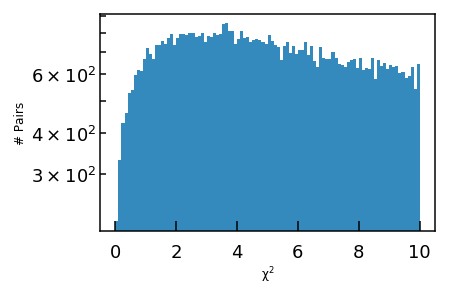

In [40]:
plt.hist(chisqs[chisqs < 10.], bins=100)
plt.xlabel('$\chi^2$')
plt.ylabel('# Pairs')
plt.yscale('log')

In [42]:
duplicates = np.zeros_like(chisqs)
for k,(i,j) in enumerate(tested_pair_ids):
    if (j,i) in tested_pair_ids:
        duplicates[k] = 1

In [43]:
np.sum(duplicates)

4203.0

In [44]:
pairs = tested_pair_ids[chisqs < 10.]
all_pair_members = np.unique(pairs)

In [71]:
np.savetxt('pair_member_designations.txt', all_pair_members, fmt='%s')

In [127]:
tab = plot_table[np.isin(plot_table['designation'],all_pair_members)]
tab = unique(tab)

In [128]:
print(len(tab))

43953


In [129]:
amplitude = 1e5
tab['radial_velocity'] *= amplitude
tab['pmra'] *= amplitude
tab['pmdec'] *= amplitude
tab['parallax'] *= amplitude

In [130]:
mag = tab['phot_g_mean_mag']
scnow = coord.SkyCoord(ra=np.array(tab['ra'])*u.deg, 
                        dec=np.array(tab['dec'])*u.deg, 
                        distance=(np.array(tab['parallax'])*u.mas).to(u.pc, u.parallax()),
                        radial_velocity=np.array(tab['radial_velocity'])*u.km/u.s,
                        pm_ra_cosdec=np.array(tab['pmra'])*u.mas/u.yr, 
                        pm_dec=np.array(tab['pmdec'])*u.mas/u.yr, 
                        obstime=gaia_time
                        )

In [131]:
def animfunc(t, xlim, ylim, ax):
    sclater = scnow.apply_space_motion(new_obstime=gaia_time + t * u.yr)
    
    ax.cla()
    ax.set_title('Kepler field, T={:,.0f} years'.format(t*amplitude), fontsize=18)
    s = ax.scatter(sclater.ra.deg, sclater.dec.deg, c=np.log10(sclater.distance.value), 
               **scatkwargs)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel('Right Ascension (degrees)', fontsize=16)
    ax.set_xlabel('Declination (degrees)', fontsize=16)
    ax.grid(alpha=.5)

In [132]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot()

scatkwargs = dict(alpha=.7, s=3, cmap='viridis')

times = np.linspace(-5., 0., 51)
times = np.append(times, np.zeros(20))
times = np.append(times, np.linspace(0., 5., 51))

anim1 = animation.FuncAnimation(fig, animfunc, times,
                                fargs=([275,305], [33,55], ax), 
                                interval=50)

plt.close(fig)
anim1.save('pair_propermotions.gif', dpi=80, writer='imagemagick')
#HTML(anim1.to_html5_video())